<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter
   

In [74]:
import pandas as pd
import psycopg2
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore') #Немного почистим предупреждения от панды

In [75]:
# вставьте сюда параметры подключения из юнита 1. Работа с базой данных из Python 

#Блок входа в базу данных Slillfactory без засвета параметров
db_params = pd.read_csv('/Users/hotdonkey/Documents/GitHub/data_science_learning/Project_2/db_project_sql.csv', sep=';')

connection = psycopg2.connect(
    dbname=db_params['DBNAME'].values[0],
    user=db_params['USER'].values[0],
    host=db_params['HOST'].values[0],
    password=db_params['PASSWORD'].values[0],
    port=db_params['PORT'].values[0]
)

In [76]:
#В моем случае не пригодилось, но оставил для проверяющего, для себя закоментил что бы не мешалось
'''DBNAME = None
USER = None
HOST = None
PASSWORD = None 
PORT = None

connection = psycopg2.connect(
    dbname=DBNAME,
    user=USER,
    host=HOST,
    password=PASSWORD,
    port=PORT
)'''

'DBNAME = None\nUSER = None\nHOST = None\nPASSWORD = None \nPORT = None\n\nconnection = psycopg2.connect(\n    dbname=DBNAME,\n    user=USER,\n    host=HOST,\n    password=PASSWORD,\n    port=PORT\n)'

___

# Юнит 3. Предварительный анализ данных

#### 1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [77]:
query_3_1 =  '''SELECT *
                FROM public.vacancies'''
vacancies_df = pd.read_sql(query_3_1,connection)
cnt_of_vac = vacancies_df.shape[0]
cnt_of_vac

49197

#### Результат запроса
##### Количество вакансий на ресурсе составляет: 49 197 вакансий.

___

#### 2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [78]:
query_3_2 =  '''SELECT *
                FROM public.employers'''
employers_df = pd.read_sql(query_3_2, connection)
employers_df.shape[0]

23501

#### Результат запроса
##### Количество работодателей на ресурсе составляет: 23 501.

___

#### 3. Посчитате с помощью запроса количество регионов (таблица areas).

In [79]:
query_3_3 =  '''SELECT count(*)
                FROM public.areas'''
areas_df = pd.read_sql(query_3_3, connection)
areas_df

,count
0,1362


#### Результат запроса
#### Количество регионов равно 1 362

___

#### 4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [80]:
query_3_4 =  '''SELECT count(*)
                FROM public.industries'''
industries_df = pd.read_sql(query_3_4, connection)
industries_df

,count
0,294


#### Результат запроса
#### Количкство сфер деятельности равно 294

***

### Количество вакансий на ресурсе составляет порядка 50 тыс. при количестве работодателей в 23,5 тыс., коилчестве сфер деятельности ~ 300 и регионов 1 362. На данный момент можно судить о достаточности данных для проведения дальнейшего статистического анализа и выявления закономерностей в данных.

___

# Юнит 4. Детальный анализ вакансий

___

#### 1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
#### Отсортируйте по количеству вакансий в порядке убывания.

In [81]:
query_4_1 =  '''SELECT 
                    a.name as area,
                    count(v.id) as cnt
                FROM 
                    public.vacancies as v
                JOIN
                    public.areas as a on v.area_id = a.id
                GROUP BY 1
                ORDER BY 2 DESC
'''
vac_per_area = pd.read_sql(query_4_1, connection)
vac_per_area.head(10)

,area,cnt
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892
5,Екатеринбург,1698
6,Нижний Новгород,1670
7,Казань,1415
8,Краснодар,1301
9,Самара,1144


Text(0.5, 1.0, 'Количество вакансий по регионам')

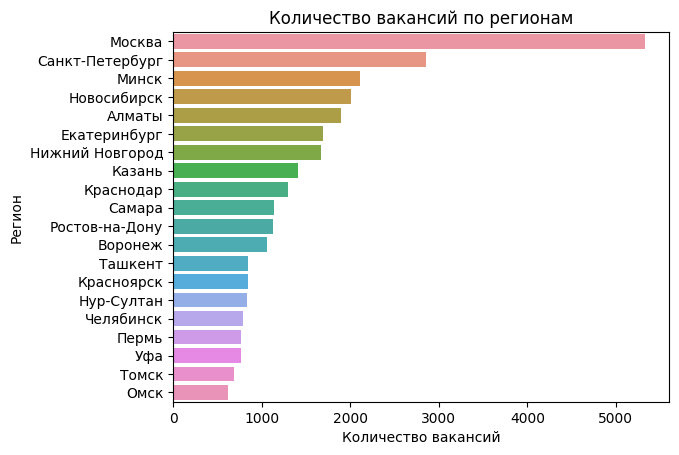

In [104]:
area_graph = sns.barplot(
    data=vac_per_area.head(20),
    x='cnt',
    y='area'
)
area_graph.set_xlabel('Количество вакансий')
area_graph.set_ylabel('Регион')
area_graph.set_title('Количество вакансий по регионам')

#### Результат запроса
#### Наибольшее количество вакансий сконцентрировано в Москве, стоит так же отметить почти двукратный разрыв между 1 и 2 номерами чарта, разрыв в количестве вакансий между нижеследующими ренионами не столь резкий.

___

#### 2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [82]:
query_4_2 =  '''SELECT 
                    COUNT(*)
                FROM 
                    public.vacancies as v
                WHERE
                (v.salary_from IS NOT NULL)
                OR (v.salary_to IS NOT NULL)
'''
not_null_sal = pd.read_sql(query_4_2, connection)
not_null_sal

,count
0,24073


#### Результат запроса
#### В 24 073 вакансий заполнено одно из полей касающееся информации о зарплате, по большей части не пропускается заполнение поля стартовой зарплаты, в целом это предсказуемо для возможности обеспечения мобильности в согласовании финального ценника на собеседовании.

___

#### 3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [83]:
query_4_3 =  '''SELECT 
                    ROUND(AVG(v.salary_from)) as avg_from,
                    ROUND(AVG(v.salary_to)) as avg_to
                FROM 
                    public.vacancies as v
'''
mean_sal = pd.read_sql(query_4_3, connection)
mean_sal

,avg_from,avg_to
0,71065.0,110537.0


#### Результат запроса
#### В среднем старт зарплат начинается с 71 тыс.руб. и оканчивается на 110,5 тыс.руб.

___

#### 4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [84]:
query_4_4 =  '''SELECT 
	                v.schedule,
	                v.employment,
	                COUNT(*)
                FROM 
                    public.vacancies as v
                GROUP BY 1,2
                ORDER BY 3 DESC
'''
empl_type = pd.read_sql(query_4_4, connection)
empl_type

,schedule,employment,count
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940
5,Полный день,Стажировка,569
6,Вахтовый метод,Полная занятость,367
7,Полный день,Частичная занятость,347
8,Гибкий график,Частичная занятость,312
9,Полный день,Проектная работа,141


#### Результат запроса
#### Наиболее распространенным сочетанием является полная занятость на полный день, т.е. стандартный тип трудоустройства, стоит отметить колоссальный разрыв в численности между данной и остальными группами.

___

#### 5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [110]:
query_4_5 =  '''SELECT 
	                v.experience,
	                COUNT(*)
                FROM 
                    public.vacancies as v
                GROUP BY 1
                ORDER BY 2
'''
exp_type = pd.read_sql(query_4_5, connection)
exp_type

,experience,count
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


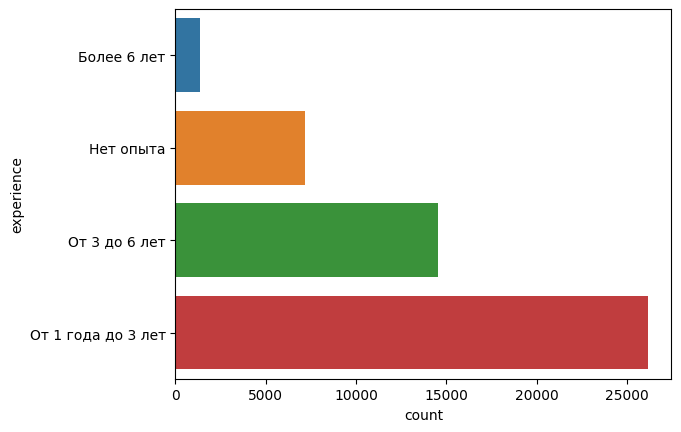

In [109]:
sns.barplot(
    data=exp_type,
    x='count',
    y='experience'
);

#### Результат запроса
#### Наибольшее количество соискателей обладают опытом в диапазоне от 1 до 3 лет: 26 152 чел.
#### Далее идет группа от 3 до 6 лет: 14 511 чел.
#### Без опыта работы: 7 197 чел.
#### И замыкающая группа более 6 лет: 1 337 чел.
#### Что примечательно, наибольшим спросом у работодателя пользуются работники со средним и малым опытом работы. Данный момент требует особого внимания, т.к. может являться сигналом для целого спектра явлений в экономической, социальной и научно-производственной сферах, не говоря уже о важности для таргетирования в рамках HH, но это уже выходит за рамки краткого анализа.

***

### Наибольшая концентрация вакансий в процентном выражении наблюдается в Москве, рпспределение по другим регионам имеет более равномерный характер распределения, что говорит о волатильности рынко Московского региона.
### Средний коридор по зп указывается работодателем в диапазоне 71 - 105 тыс. руб. при этом половина вакансий не имеет потолка зарплат в анкете, что говорит о желании работодателя сформировать иллюзию возможности роста (любая область компетенции имеет пороговые значения по зп, переходя которые соискатель меняет должность), а так же иметь степень свободы на собеседовании с соискателем.
### Наиболее популярными у работодателя являются 2 группы по опыту, это 1-3 года и 3-6 лет, что говорит о заинтересованности работодателей в соискателях с малым и средним опытом, возможно это обусловленно тем что данные категории требуют наименьшего вклада в их развитие и оказывают наименьшее сопротивление при вливании в коллектив.
### Так же стоит отметить, что наиболее распространенная связка по графику это полная занятость - полный рабочий день, т.е. классическое расписание.

___

# Юнит 5. Анализ работодателей

#### 1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [86]:
query_5_1 =  '''SELECT 
	                e."name" as company_name,
	                COUNT(*) as number_of_vacancies
                FROM 
                    public.vacancies as v
                JOIN
                    public.employers AS e ON e.id = v.employer_id
                GROUP BY 1
                ORDER BY 2 desc
                LIMIT 5
'''
employers = pd.read_sql(query_5_1, connection)
employers

,company_name,number_of_vacancies
0,Яндекс,1933
1,Ростелеком,491
2,Тинькофф,444
3,СБЕР,428
4,Газпром нефть,331


#### Результат запроса
#### Наибольшее число вакансий с пятикратным отрывом принадлежит Яндексу, что может свидетельствовать либо о крупном росте и потребности в кадрах, либо о текучке. Нужен более пристальный анализ ввиду того, что распределение числа вакансий имеет весьма неоднородный рисунок, с учетом того, что в той или иной степени все компании из пятерки в той или иной степени (в случае с газпромом не так ондозначно) являются представителями IT сектора.

___

#### 2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
#### Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [87]:
query_5_2 =  '''SELECT
                    a."name" as region_name,
	                COUNT(v.*) number_of_vacancies,
	                COUNT(e."name") as number_of_employers
                FROM 
                    public.areas as a
                LEFT JOIN
                    public.vacancies as v on a.id = v.area_id
                JOIN
                    public.employers as e on a.id = e.area
                GROUP by 1
                HAVING COUNT(v.*) = 0
                ORDER BY 3 DESC
                
'''
area = pd.read_sql(query_5_2, connection)
area.head()

,region_name,number_of_vacancies,number_of_employers
0,Россия,0,410
1,Казахстан,0,207
2,Московская область,0,75
3,Краснодарский край,0,19
4,Беларусь,0,18


#### Результат запроса
#### Наибольшее число работодателей не указавших вакансию находится в России, исходя из того, что далее в чарте идут регионы, некоторые из которых, являются частью региона Россия, мы можем заключить что таблица employers требует некоторой систематизации, и не должна содержать в перемешку множества и входящие в них подмножества, т.е. разумным шагом было бы создание таблицы регионов включающая в себя регионы более высокого порядка(страны), а в таблице areas включить внешний ключ на эту таблицу.

___

#### 3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [88]:
query_5_3 =  '''SELECT
                    e."name" employer_name,
	                COUNT(DISTINCT v.area_id) region_qty
                FROM
                    public.vacancies as v
                JOIN
                    public.employers as e ON e.id = v.employer_id
                GROUP BY 1
                ORDER BY 2 DESC
'''
employer_area = pd.read_sql(query_5_3, connection)
employer_area.head()

,employer_name,region_qty
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71


#### Результат запроса
#### На первом месте по охвату регионов стоит Яндекс, что согласуется с предыдущим анализом количества вакансий и говорит о том, что, возможно, в данный период времени компания "пылесосила" рынок. 


---

#### 4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [89]:
query_5_4 =  '''SELECT 
                    employers.id
                FROM 
                    public.employers
                EXCEPT 
                SELECT 
                    employers_industries.employer_id
                FROM
	                public.employers_industries                
'''
empty_empl = pd.read_sql(query_5_4, connection)
f'Количество работодателей не указавшиъ сферу деятельности: {len(empty_empl)} \
или {round(len(empty_empl)/len(employers_df)*100)}% от общего количества работодателей'

'Количество работодателей не указавшиъ сферу деятельности: 8419 или 36% от общего количества работодателей'

#### Результат запроса
#### Количество работодателей не указавшиъ сферу деятельности: 8419 или 36% от общего количества работодателей. Высокий процент работодателей по каким-то причинам не указали сферу деятельности, что может осложнить анализ данного сегмента данных в будущем.

---

#### 5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [90]:
query_5_5 =  '''SELECT 
                    e."name"
                FROM
                    public.employers_industries as i
                JOIN
                    public.employers as e on e.id = i.employer_id
                GROUP BY 1
                HAVING COUNT(i.industry_id) = 4
                ORDER BY 1
                OFFSET 2
                LIMIT 1               
'''
temp_var = pd.read_sql(query_5_5, connection)
temp_var

,name
0,2ГИС


#### Результат запроса
#### На третьем месте в алфавитном списке компаний указавших 4 вида деятельности находится 2ГИС

---

#### 6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.

In [91]:
query_5_6 =  '''SELECT 
                    COUNT(e."name")
                FROM public.employers as e
                JOIN
                    public.employers_industries as e_i ON e_i.employer_id = e.id
                JOIN
                    public.industries as i ON i.id = e_i.industry_id
                WHERE i."name" LIKE 'Разработка%'              
'''
temp_var = pd.read_sql(query_5_6, connection)
temp_var

,count
0,3553


#### Результат запроса
#### Своей сферой деятельности (помним что некоторые работодатели указали более 1) в формулировке "Разработка ПО" указали 3 553 работодателя, в разрезе общего количества эта цифра достаточно низкая, с учетом того что основной массив вакансий представлен в сфере ИТ, вырисовывается интересная картина.

---

#### 7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

#### Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

#### Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [92]:
# код для получения списка городов-милионников
url = 'https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8'
req = requests.get(url)
soup = BeautifulSoup(req.text, 'html.parser')
million_list = []

for row in soup.find_all('td'):
    for cell in row.find_all('a'):
        million_list.append(cell.get('title'))

for i in million_list:
    if i is None:
        million_list.remove(i)

million_list = million_list[0:16]
million_tuple = tuple(million_list)

In [107]:
query_5_7 =  f'''SELECT
                    areas."name" as region_name,
	                COUNT(*) as cnt
                FROM 
                    public.vacancies
                JOIN
                    public.areas ON areas.id = vacancies.area_id
                JOIN
                    public.employers ON employers.id = vacancies.employer_id
                WHERE 
                (employers."name" = 'Яндекс') AND
                (areas."name" IN {million_tuple})
                GROUP BY 1
'''
yandex = pd.read_sql(query_5_7, connection)
yandex_total = pd.DataFrame(data={'region_name':['Total'],'cnt':[yandex['cnt'].sum()]})
yandex = yandex.append(yandex_total,ignore_index=True)
yandex

,region_name,cnt
0,Волгоград,24
1,Воронеж,32
2,Екатеринбург,39
3,Казань,25
4,Краснодар,30
5,Красноярск,23
6,Москва,54
7,Нижний Новгород,36
8,Новосибирск,35
9,Омск,21


#### Результат запроса
#### Распределение вакансий по регионам достаточно равномерно по городам миллионикам, с двойным отрывом по Москве и СПб, что закономерно в переложении на количество жителей в данных городах. Суммарное количество вакансий от Яндекса в городах-миллиониках совставляет 485.

***

### Высокий уровень преобладания компаний IT-сектора, с лидерством по количеству вакансий у компании Яндекс. Достаточно широкий региональный охфат вакансий с предсказуемым акцентом на городах-миллиониках и зарубежных крупных региональных центрах.
### Нужно отметить некоторую неполноту данных (треть работодателей не указали свою сферу деятельности), а так же некоторое нарушение структурной целостности таблиц (задание 2 данного блока)

---

# Юнит 6. Предметный анализ

#### 1. Сколько вакансий имеет отношение к данным?

#### Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

#### *Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [94]:
query_6_1 =  '''SELECT 
                    COUNT(*)
                FROM 
                    public.vacancies
                WHERE 
                    ("name" LIKE '%data%') OR 
	                ("name" LIKE '%Data%') OR
                    ("name" LIKE '%данн%') OR 
	                ("name" LIKE '%Данн%') OR 
	                ("name" LIKE '%DATA%')
'''
data_connected_vac = pd.read_sql(query_6_1, connection)

f'Количество вакансий связаных с ключевым словом:{data_connected_vac} \
или {round(data_connected_vac/cnt_of_vac*100,2)}% от общего количества вакансий'

'Количество вакансий связаных с ключевым словом:   count\n0   1771 или    count\n0    3.6% от общего количества вакансий'

#### Результат запроса
#### В данном блоке данных 1 771 вакансия связаных с "данными" или "data" в том или ином виде, что состовдяет порядка 3,6% от общего количества вакансий в датасете.

---

#### 2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
#### Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
#### * 'data scientist'
#### * 'data science'
#### * 'исследователь данных'
#### * 'ML' (здесь не нужно брать вакансии по HTML)
#### * 'machine learning'
#### * 'машинн%обучен%'

#### ** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

#### Считаем вакансиями для специалистов уровня Junior следующие:
#### * в названии есть слово 'junior' *или*
#### * требуемый опыт — Нет опыта *или*
#### * тип трудоустройства — Стажировка.
 

In [108]:
query_6_2 =  '''SELECT
	                *	
                FROM 
                    vacancies as v
                WHERE 
                    (LOWER (v.name) LIKE '%data scientist%' OR 
	                LOWER (v.name) LIKE '%data science%' OR 
	                LOWER (v.name) LIKE '%исследователь данных%' OR 
	                (v.name LIKE '%ML%' AND v.name NOT LIKE '%HTML%') OR 
	                LOWER (v.name) LIKE '%machine learning%' OR 
	                LOWER (v.name) LIKE '%машинн%обучен%')
                    
                    AND (LOWER (v.name) LIKE '%junior%' OR 
		            v.experience LIKE 'Нет опыта' OR 
		            v.employment LIKE 'Стажировка')
'''
junior_ds = pd.read_sql(query_6_2, connection)
junior_ds.shape[0]

51

#### Результат запроса
#### 51 вакансия за джунами датасаентистами, весьма малораспространенныый тип вакансий исходя из общего количества.

---

#### 3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

#### ** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [96]:
query_6_3 =  '''SELECT
	                *	
                FROM 
                    vacancies as v
                WHERE 
                    (LOWER (v.name) LIKE '%data scientist%' OR 
	                LOWER (v.name) LIKE '%data science%' OR 
	                LOWER (v.name) LIKE '%исследователь данных%' OR 
	                (v.name LIKE '%ML%' AND v.name NOT LIKE '%HTML%') OR 
	                LOWER (v.name) LIKE '%machine learning%' OR 
	                LOWER (v.name) LIKE '%машинн%обучен%')
                    
                    AND (LOWER (v.key_skills) LIKE '%sql%' OR 
		            LOWER (v.key_skills) LIKE '%postgres%')
'''
sql_skill_ds = pd.read_sql(query_6_3, connection)
sql_skill_ds.shape[0]

201

#### Результат запроса
#### 201 вакансия требует как один из ключевых навыков умение взаимодействовать с СУБД.

---

#### 4. Проверьте, насколько популярен Python в требованиях работодателей к DS.Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

#### ** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [97]:
query_6_4 =  '''SELECT
	                *	
                FROM 
                    vacancies as v
                WHERE 
                    (LOWER (v.name) LIKE '%data scientist%' OR 
	                LOWER (v.name) LIKE '%data science%' OR 
	                LOWER (v.name) LIKE '%исследователь данных%' OR 
	                (v.name LIKE '%ML%' AND v.name NOT LIKE '%HTML%') OR 
	                LOWER (v.name) LIKE '%machine learning%' OR 
	                LOWER (v.name) LIKE '%машинн%обучен%')
                    
                    AND (LOWER (v.key_skills) LIKE '%python%')
'''
python_ds = pd.read_sql(query_6_4, connection)
python_ds.shape[0]

351

#### Результат запроса
#### 351 вакансия требует как один из ключевых навыков умение программировать на python.

---

#### 5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
#### Ответ округлите до двух знаков после точки-разделителя.

In [98]:
query_6_5 =  '''SELECT
                    AVG(LENGTH(v.key_skills) - LENGTH(replace(v.key_skills, CHR(9), '')) +1)	
                FROM 
                    vacancies as v
                WHERE 
                    (LOWER (v.name) LIKE '%data scientist%' OR 
	                LOWER (v.name) LIKE '%data science%' OR 
	                LOWER (v.name) LIKE '%исследователь данных%' OR 
	                (v.name LIKE '%ML%' AND v.name NOT LIKE '%HTML%') OR 
	                LOWER (v.name) LIKE '%machine learning%' OR 
	                LOWER (v.name) LIKE '%машинн%обучен%')
'''
avg_skill_ds = pd.read_sql(query_6_5, connection)
round(avg_skill_ds.iloc[0],2)

avg    6.41
Name: 0, dtype: float64

#### Результат запроса
#### В среднем на вакансию с DS требуются кандидаты обладающие 6-7 ключевыми навыками, что говорит о высоком уровне ожидаемых компетенций.

---

#### 6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

#### При решении задачи примите во внимание следующее:
#### 1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
#### 2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
#### 3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

#### Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [99]:
query_6_6 =  '''SELECT
                    v.experience,
                    round(avg(coalesce(
		                (v.salary_from+v.salary_to)/2, 
		                v.salary_from, 
		                v.salary_to)),0)
                FROM public.vacancies as v
                WHERE 
                    (LOWER (v.name) LIKE '%data scientist%' OR 
	                LOWER (v.name) LIKE '%data science%' OR 
	                LOWER (v.name) LIKE '%исследователь данных%' OR 
	                (v.name LIKE '%ML%' AND v.name NOT LIKE '%HTML%') OR 
	                LOWER (v.name) LIKE '%machine learning%' OR 
	                LOWER (v.name) LIKE '%машинн%обучен%')
                    AND (salary_from IS NOT NULL OR salary_to IS NOT NULL)
                GROUP BY 1
'''
avg_sallary_ds = pd.read_sql(query_6_6, connection)
avg_sallary_ds

,experience,round
0,Нет опыта,74643.0
1,От 1 года до 3 лет,139675.0
2,От 3 до 6 лет,243115.0


#### Результат запроса
#### Можно сказать, что прогрессия зп плюс минус поступательна - идет примерное удвоение зп при переходе между заданными уровнями квалификации, конечно для определения характера прогрессии и условного модификатора зп групп мало, но можно все же предположить, что опыт 6-9 лет будет оплачиваться вдвое выше чем опыт 3-6. Так же стоит отметить, что отрасль DS выглядит весьма интересно для новичков с учетом более высокой средней зп.

***

#### Выводы по предметному анализу
#### При анализе предметной области DS было выявлено несколько моментов:
#### 1. Количество вакансий в области DS имеет достаточно узкое представление в разрезе общего количества вакансий, что говорит о "свежести" данной области на рынке РФ.
#### 2. Количество требуемых компетенций в среднем колеблется в районе 6 навыков, что говорит о требовательности профессии к навыкам работника и может являться косвенным признаком достаточно низкого количества вакансий рассмотренного в пункте выше.
#### 3. Ключевыми навыками для датасайентиста можно выделить умение программировать на python, умение работать с СУБД.
#### 4. Зарплата в области имеет достаточную прогнозируемость в прогрессии. а так же имеет для категории без опыта показатель выше средней.

---

### Общий вывод по проекту

#### Подводя итоги можно отметить следующие моменты:
##### 1. Рынок вакансий насыщен IT специальностями с достаточно высокими средними зарплатами и достаточно низкими требованиями к опыту.
##### 2. Ряд компаний, в частности Яндекс реализует стратегию экспансии или "пылесосит" кадры на рынке труда, обычно подобное поведение заставляет конкурентов вести себя подобным же образом, что может приводить к увеличению зп и снижению требований к кандидатом, обычно это триггер для формирования "пузыря" на рынке, что в конечном счете приводит к резкому развороту и сворачиванию как масштабов проектов, так и масштабов найма.
##### 3. Сектор DS представлен достаточно узко, что, исходя из мировой тенденции, является не флагом невостребованности, а скорее зарождения направления, так же надо учитывать, что количество ключевых скилов в данной отрасли в среднем превосходит другие группы представленных вакансий и накладывает жесткие рамки для кандидатов.
##### 4. Сектор DS имеет достаточно высокий средний уровень зп для всех представленных групп опыта, что так же может стимулировать дальнейшее расширение предложения на рынке труда ввиду увеличивающегося спроса со стороны соискателей.
##### 5. Пессимистичное отсупление. Ввиду того факта, что на рынке IT формируется пузырь, есть вероятность, что после коллапса область DS может, как чувствительная по слабой представленности, схлопнуться на ближайшие 2-3 года полностью, повторив судьбу ряда специальностей эпохи дот-коммов и кризиса 2008 года.